In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from textblob import TextBlob
import matplotlib.pyplot as plt
# Download NLTK resources
#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import keras_tuner as kt
#from transformers import BertTokenizer, TFBertModel
from transformers import GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
# Assume reviews.csv columns: UserID, MovieID, ReviewText, Rating

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# Define your PostgreSQL connection parameters
db_user = 'postgres'
db_password = 'admin'
db_host = 'localhost'
db_port = '5433'
db_name = 'postgres'

# Create a SQLAlchemy engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')




In [5]:
# Define your SQL query. You can modify this query to filter rows as needed.
query = """
SELECT *
FROM playstore_game_reviews
LIMIT 100000;  -- adjust this limit based on your memory and needs
"""

# Read the query results into a DataFrame
df = pd.read_sql(query, engine)

print("Subset of data loaded into DataFrame:")
print(df.head())


Subset of data loaded into DataFrame:
                           title  \
0  Grand Theft Auto: San Andreas   
1  Grand Theft Auto: San Andreas   
2  Grand Theft Auto: San Andreas   
3  Grand Theft Auto: San Andreas   
4  Grand Theft Auto: San Andreas   

                                         description  \
0  Five years ago, Carl Johnson escaped from the ...   
1  Five years ago, Carl Johnson escaped from the ...   
2  Five years ago, Carl Johnson escaped from the ...   
3  Five years ago, Carl Johnson escaped from the ...   
4  Five years ago, Carl Johnson escaped from the ...   

                         summary  minInstalls   genre      genreId  \
0  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
1  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
2  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
3  Grand Theft Auto: San Andreas      1000000  Action  GAME_ACTION   
4  Grand Theft Auto: San Andreas      1000000  Action  GAM

In [7]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1


In [9]:
df.describe()

,minInstalls,score
count,1.000000e+05,100000.000000
mean,2.120156e+06,3.280300
std,3.350316e+06,1.531508
min,5.000000e+03,1.000000
25%,5.000000e+05,2.000000
50%,1.000000e+06,4.000000
75%,1.000000e+06,5.000000
max,1.000000e+07,5.000000


In [11]:
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1


In [13]:
# Standard English stopwords
standard_stopwords = set(stopwords.words('english'))

# Domain-specific stopwords for movie reviews (extend as needed)
domain_stopwords = {"game", "app", "play", "install","downloads"}

# Combined stopwords
all_stopwords = standard_stopwords.union(domain_stopwords)

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_review(text, method='lemmatization', do_spell_correction=True, min_words=3):
    """
    Clean and normalize text reviews.
    
    Parameters:
      - text: the input review text.
      - method: choose between 'lemmatization' or 'stemming'.
      - do_spell_correction: if True, apply spell correction using TextBlob.
      - min_words: minimum number of words required; otherwise, return empty string.
    
    Returns:
      Cleaned text.
    """
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags if any
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    
    # Optionally perform spell correction (Note: can be slow on large datasets)
    #if do_spell_correction:
     #   try:
     #       text = str(TextBlob(text).correct())
     #   except Exception as e:
     #       # In case spell correction fails, use the original text.
     #       pass
    
    # Tokenize text
    tokens = text.split()
    
    # Filter out tokens that are in our stopwords list
    tokens = [word for word in tokens if word not in all_stopwords]
    
    # Ensure the review has a minimum number of words; otherwise, mark as empty.
    if len(tokens) < min_words:
        return ""
    
    # Apply stemming or lemmatization as desired
    if method == 'stemming':
        tokens = [stemmer.stem(word) for word in tokens]
    else:  # default is lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

# Example usage on your DataFrame:
# Replace 'text' with the appropriate column name in your dataset
df['cleaned_review'] = df['content'].apply(clean_review)
df.head()

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1,well amazing one day stopped working everytime...
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1,using gamepad cannot move cursor anywhere righ...
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1,played earlier several time pc really easy mob...
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1,really wanted like control beyond irritating g...
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1,keep stopping even playable want money back pl...


In [15]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_rating(text):
    sentiment = sid.polarity_scores(text)
    # VADER compound score is in [-1, 1]. We'll map it to a 1-5 scale.
    compound = sentiment['compound']
    rating = np.interp(compound, [-1, 1], [1, 5])
    return rating

In [17]:
if 'rating' not in df.columns or df['rating'].isnull().any():
    df['inferred_rating'] = df['cleaned_review'].apply(get_sentiment_rating)
    df['rating'] = df['inferred_rating']
    


In [19]:
df.head(10)

,title,description,summary,minInstalls,genre,genreId,appId,reviewId,userName,content,score,cleaned_review,inferred_rating,rating
0,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHc4bk4qFmjn6UVlvGvDQnrl4MPfI4eoVHkeVh...,jerrod carson,Well it was an amazing game until one day it j...,1,well amazing one day stopped working everytime...,4.4860,4.4860
1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOF51K5A6irQCgu2hLvoeUef1Ctzwwgokay01QJ...,Jose Quintero,"When using a gamepad, I cannot move the cursor...",1,using gamepad cannot move cursor anywhere righ...,4.4368,4.4368
2,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFPaxDYBnoFlcSA8VSevfID1LO58mjz6IGs4Mu...,Chintan Sureliya,Have played this game earlier several times on...,1,played earlier several time pc really easy mob...,4.4178,4.4178
3,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFf5_Hy2Slvh4lZPi3oXq51yKnDmnjfbbtqFXq...,Marty Mayfield,I really wanted to like this game. The control...,1,really wanted like control beyond irritating g...,3.2268,3.2268
4,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEktSrayZreOdojT7bKWI3OOTavr0GbEDFzUOy...,joesph young,The app keeps stopping it's not even playable ...,1,keep stopping even playable want money back pl...,3.9558,3.9558
5,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOG-g1U_ti4680ArFIvjhCCsFvBkou1k279MKgh...,Pac Man,Let's hope it works better 🙏 ken use Fix your ...,1,let hope work better ken use fix say new updat...,4.8786,4.8786
6,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOHVuxYr5t_9wfeO1jydmxu0jD_RQxzo0IDUMJ_...,clayton0127,"Absolutely horrible. It crashes randomly, whic...",1,absolutely horrible crash randomly doesnt happ...,1.1888,1.1888
7,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOEve6pYDz-wHsTiVs08EUyUpYq1KsbKTG5RJXV...,Ashish Singh,The vehicles seem to drag in one direction whi...,1,vehicle seem drag one direction make flying dr...,1.4852,1.4852
8,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOFSR_ASJVPpGTh8IGJrSHqPysdUjD0sWJ55wnB...,Walty Walt,"One big issue in this game is that, when an ex...",1,one big issue external keyboard connected pres...,3.6364,3.6364
9,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,Action,GAME_ACTION,com.rockstargames.gtasa,gp:AOqpTOGA5FHvk6tbvbqJxnKKtDHzUYk3NbK_tsjHWP4...,Craig Johnson,"It stuck at the ""mike toreno"" mission..when i ...",1,stuck mike toreno mission finished shooting va...,3.2054,3.2054


In [21]:


# Encode user and app IDs based on the new dataset's column names
user_ids = df['userName'].unique().tolist()  # Unique user names
app_ids = df['appId'].unique().tolist()  # Unique app IDs

# Create mappings from user and app IDs to numeric indices
user2idx = {user: idx for idx, user in enumerate(user_ids)}
app2idx = {app: idx for idx, app in enumerate(app_ids)}

# Apply mappings to create numerical indices
df['user_idx'] = df['userName'].map(user2idx)
df['app_idx'] = df['appId'].map(app2idx)



In [23]:

# Initialize the GPT tokenizer (for example, DistilGPT2)
from transformers import GPT2TokenizerFast
gpt_tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")

# Set the pad token to the EOS token (or any token of your choice)
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt_encoder = TFGPT2Model.from_pretrained("distilgpt2")



All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [25]:
# Function to tokenize reviews using DistilGPT
def encode_reviews_for_gpt(texts, max_length=128):
    encoding = gpt_tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    return encoding['input_ids'], encoding['attention_mask']


In [27]:
X_input_ids, X_attention_mask = encode_reviews_for_gpt(df['cleaned_review'], max_length=128)
X_input_ids = X_input_ids.numpy()
X_attention_mask = X_attention_mask.numpy()


In [29]:
# Prepare training data 
X_user = np.array(df['user_idx'].tolist())
X_app  = np.array(df['app_idx'].tolist())  
y = np.array(df['rating'].tolist())

print("User input shape:", X_user.shape)
print("App input shape:", X_app.shape)  
print("Ratings shape:", y.shape)



User input shape: (100000,)
App input shape: (100000,)
Ratings shape: (100000,)


In [31]:
X_user_train, X_user_test, X_app_train, X_app_test, \
X_input_ids_train, X_input_ids_test, X_attention_mask_train, X_attention_mask_test, \
y_train, y_test = train_test_split(
    X_user, X_app, X_input_ids, X_attention_mask, y, test_size=0.2, random_state=42
)


In [33]:
num_users = len(user2idx)
num_apps = len(app2idx)



In [35]:
def build_transformer_model(hp):
   
    user_input = Input(shape=(1,), name='user_input')
    app_input = Input(shape=(1,), name='app_input')  

    # DistilGPT2 review inputs
    review_input_ids = Input(shape=(128,), dtype=tf.int32, name='review_input_ids')
    review_attention_mask = Input(shape=(128,), dtype=tf.int32, name='review_attention_mask')

    # User Embedding
    user_embedding_dim = hp.Choice('user_embedding_dim', values=[8, 10, 16])
    user_embedding = Embedding(input_dim=len(user2idx), output_dim=user_embedding_dim, name='user_embedding')(user_input)
    user_vec = Flatten(name='user_flatten')(user_embedding)

    # App Embedding
    app_embedding_dim = hp.Choice('app_embedding_dim', values=[8, 10, 16])
    app_embedding = Embedding(input_dim=len(app2idx), output_dim=app_embedding_dim, name='app_embedding')(app_input)
    app_vec = Flatten(name='app_flatten')(app_embedding)

    # Define GPT pooling function
    def gpt_pooler(inputs):
        input_ids, attention_mask = inputs
        outputs = gpt_encoder(input_ids, attention_mask=attention_mask)
        # Typically GPT models do not have a "pooler_output", so take the last token representation:
        return outputs.last_hidden_state[:, -1, :]

    # GPT pooling layer for review text
    review_vec = Lambda(gpt_pooler, output_shape=(768,), name='gpt_pooler')([review_input_ids, review_attention_mask])

    # Concatenate all features
    concat = Concatenate(name='concatenate')([user_vec, app_vec, review_vec])

    # Dense layers
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    dense1 = Dense(dense_units, activation='relu', name='dense1')(concat)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dropout_layer = Dropout(dropout_rate, name='dropout')(dense1)
    dense2 = Dense(dense_units // 2, activation='relu', name='dense2')(dropout_layer)
    output = Dense(1, activation='linear', name='rating_prediction')(dense2)

    model = Model(inputs=[user_input, app_input, review_input_ids, review_attention_mask], outputs=output)

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model



In [37]:
distilGPT_tuner = kt.RandomSearch(
    build_transformer_model,
    objective='val_loss',
    max_trials=10,
    directory='distilgpt_tuner_playstore_app_dir',
    project_name='distilgpt_app_reviews'
)

distilGPT_tuner.search(
    [X_user_train, X_app_train, X_input_ids_train, X_attention_mask_train],
    y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)





Trial 10 Complete [09h 36m 05s]
val_loss: 0.7813906669616699

Best val_loss So Far: 0.45736369490623474
Total elapsed time: 4d 09h 58m 39s


In [45]:

# Train the best DistilBERT model
best_distilGPT_hps = distilGPT_tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters for transformer model:")
print(f"User Embedding Dim: {best_distilGPT_hps.get('user_embedding_dim')}")
print(f"App Embedding Dim: {best_distilGPT_hps.get('app_embedding_dim')}")
print(f"Dense Units: {best_distilGPT_hps.get('dense_units')}")
print(f"Dropout Rate: {best_distilGPT_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_distilGPT_hps.get('learning_rate')}")

best_distilGPT_model = distilGPT_tuner.hypermodel.build(best_distilGPT_hps)
history_distilGPT = best_distilGPT_model.fit(
    [X_user_train, X_app_train, X_input_ids_train, X_attention_mask_train],  # Changed from X_movie_train to X_app_train
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)


Best hyperparameters for transformer model:
User Embedding Dim: 16
App Embedding Dim: 8
Dense Units: 128
Dropout Rate: 0.0
Learning Rate: 2.5723943682384322e-05
Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7091s 6s/step - loss: 2.7607 - mae: 1.1925 - val_loss: 0.6696 - val_mae: 0.6148
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6990s 6s/step - loss: 0.6474 - mae: 0.6056 - val_loss: 0.5618 - val_mae: 0.5446
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7021s 6s/step - loss: 0.5578 - mae: 0.5444 - val_loss: 0.5097 - val_mae: 0.5145
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6978s 6s/step - loss: 0.5132 - mae: 0.5192 - val_loss: 0.4803 - val_mae: 0.5017
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7028s 6s/step - loss: 0.4793 - mae: 0.4987 - val_loss: 0.4588 - val_mae: 0.4901
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6976s 6s/step - loss: 0.4525 - mae: 0.4816 - val_loss: 0.4400 - val_mae: 0.4733
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6955s 6s/step - loss: 0.4330 - mae: 0.4685 - val_loss: 0.4283 - v

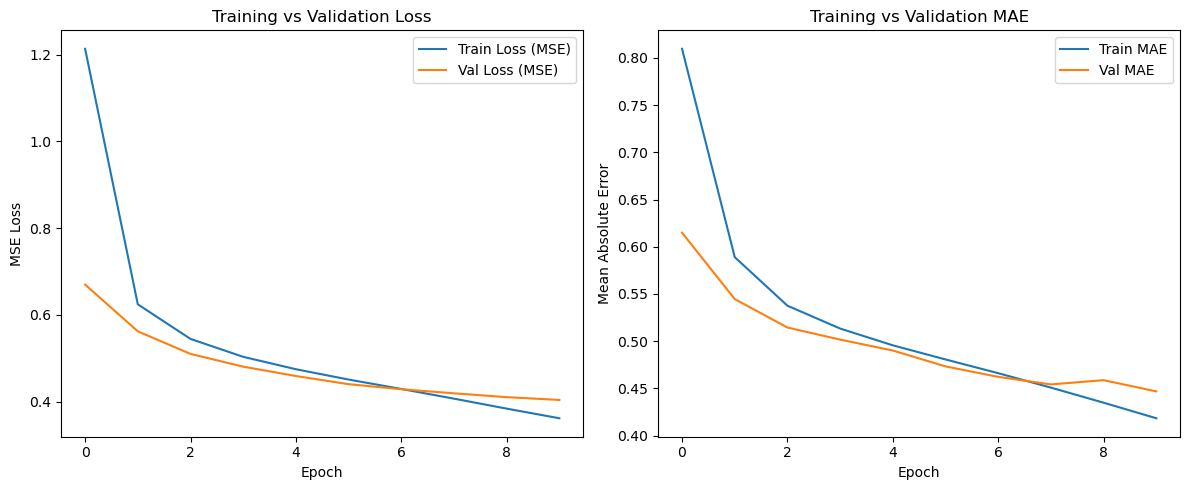

In [47]:
import matplotlib.pyplot as plt



# Plot training and validation loss and MAE
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_distilGPT.history['loss'], label='Train Loss (MSE)')
plt.plot(history_distilGPT.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history_distilGPT.history['mae'], label='Train MAE')
plt.plot(history_distilGPT.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
# Evaluate on the test set for transformer model (using app variables)
loss_t, mae_t = best_distilGPT_model.evaluate(
    [X_user_test, X_app_test, X_input_ids_test, X_attention_mask_test], y_test
)
print(f"Transformer Model Test MSE: {loss_t:.4f}, Test MAE: {mae_t:.4f}")



625/625 ━━━━━━━━━━━━━━━━━━━━ 1869s 3s/step - loss: 0.4080 - mae: 0.4511
Transformer Model Test MSE: 0.4110, Test MAE: 0.4511


In [51]:

y_pred = best_distilGPT_model.predict(
    [X_user_test, X_app_test, X_input_ids_test, X_attention_mask_test]
).flatten()



625/625 ━━━━━━━━━━━━━━━━━━━━ 1848s 3s/step


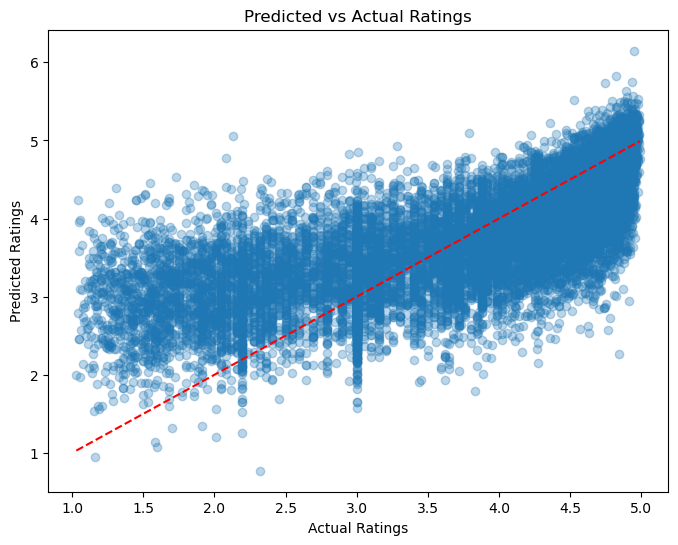

In [53]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Reference line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()



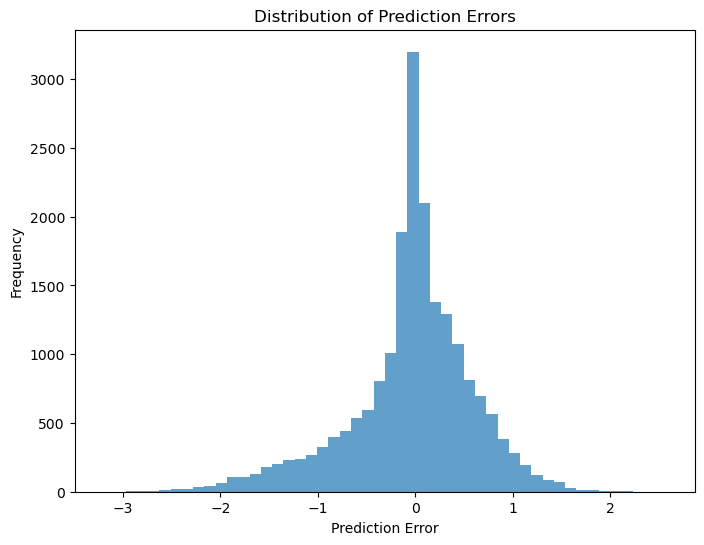

In [55]:

errors = y_test - y_pred


plt.figure(figsize=(8, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

In [57]:
import pandas as pd

# Assuming X_user_test, X_app_test, y_test, and y_pred are defined from your evaluation
test_df = pd.DataFrame({
    'user': X_user_test, 
    'app': X_app_test,  # Updated column name from movie to app
    'true_rating': y_test, 
    'predicted_rating': y_pred
})

print(test_df.head())


    user  app  true_rating  predicted_rating
0  26121   29       4.7440          4.350537
1     86   32       3.0000          3.153374
2  17630    8       4.6884          4.626168
3  67834   39       3.6364          3.718351
4  45572   43       3.0000          2.904868


In [83]:
import numpy as np

def recall_ndcg(test_df, k=10, relevance_threshold=4.0):
    """
    Computes Precision@K, Recall@K, and NDCG@K for each user and returns their averages.
    
    Parameters:
      test_df: DataFrame with columns: 'user', 'movie', 'true_rating', 'predicted_rating'
      k: the cutoff rank for evaluation
      relevance_threshold: true ratings at or above this value are considered relevant
      
    Returns:
      avg_precision, avg_recall, avg_ndcg: Average metrics across all users.
    """
    # Group the results by user
    user_groups = test_df.groupby('user')
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for user, group in user_groups:
        # Sort this user's items by predicted rating in descending order
        group_sorted = group.sort_values('predicted_rating', ascending=False)
        top_k = group_sorted.head(k)
        
        # Determine which of the top-k items are relevant
        relevant = (top_k['true_rating'] >= relevance_threshold).astype(int).values
        num_relevant_in_top_k = relevant.sum()
        
        # Calculate Precision@K for this user
        precision = num_relevant_in_top_k / k
        
        # Count the total number of relevant items for this user in the test set
        total_relevant = (group['true_rating'] >= relevance_threshold).sum()
        recall = num_relevant_in_top_k / total_relevant if total_relevant > 0 else 0.0
        
        # Compute DCG@K for this user's top-k recommendations
        dcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(relevant)])
        
        # Compute Ideal DCG (IDCG) using the best possible ranking
        # Get relevance scores (1 if rating>=threshold else 0) for all items for this user,
        # sort them in descending order, and take the top-k.
        ideal_relevances = group['true_rating'].apply(lambda x: 1 if x >= relevance_threshold else 0)
        ideal_sorted = ideal_relevances.sort_values(ascending=False).head(k).values
        idcg = sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(ideal_sorted)])
        
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
    
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    
    return avg_precision, avg_recall, avg_ndcg


In [87]:
# Assume you have already generated predictions (y_pred) and created test_df
# Set k (e.g., 10) and a relevance threshold (e.g., 4.0)
k = 10
relevance_threshold = 3.0

avg_precision, avg_recall, avg_ndcg = recall_ndcg(test_df, k=k, relevance_threshold=relevance_threshold)


print(f"Recall@{k}: {avg_recall:.4f}")
print(f"NDCG@{k}: {avg_ndcg:.4f}")


Recall@10: 0.8231
NDCG@10: 0.8229


In [65]:
# Mapping app IDs to titles
app_id_to_title = df[['appId', 'title']].drop_duplicates().set_index('appId')['title'].to_dict()


In [69]:
# Example: Predict ratings for a sample user for all apps.
sample_user = 7
all_app_indices = np.array(list(range(num_apps)))  # Changed from num_movies to num_apps
sample_user_input = np.full(shape=(num_apps,), fill_value=sample_user)

# For review inputs, you need to provide tokenized data. 
# Here we use a placeholder sequence (e.g., an empty review) for each app.
empty_reviews = pd.Series([""] * num_apps)
default_input_ids, default_attention_mask = encode_reviews_for_gpt(empty_reviews, max_length=128)
default_input_ids = default_input_ids.numpy()
default_attention_mask = default_attention_mask.numpy()

# Predict ratings using the best DistilBERT model
predicted_ratings_transformer = best_distilGPT_model.predict(
    [sample_user_input, all_app_indices, default_input_ids, default_attention_mask]
).flatten()

# Get the top 10 recommended app indices and then map them to app titles
recommended_app_indices_transformer = np.argsort(predicted_ratings_transformer)[::-1][:10]
recommended_app_titles = [app_id_to_title[app_ids[i]] for i in recommended_app_indices_transformer]

print("Top recommended app titles for user", sample_user, "using transformer model:")
for title in recommended_app_titles:
    print(title)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Top recommended app titles for user 7 using transformer model:
Monopoly - Board game classic about real-estate!
THE GAME OF LIFE 2 - More choices, more freedom!
Through the Ages
Chess - Analyze This (Pro)
League of Stickman - Best action game(Dreamsky)
Root Board Game
Minecraft
LIMBO
Carcassonne: Official Board Game -Tiles & Tactics
60 Seconds! Atomic Adventure
